In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def create_sequence_model():
    """Create CNN model for sequence data"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(33,)),
        tf.keras.layers.Embedding(21, 21, input_length=33),
        tf.keras.layers.Reshape((33, 21, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
def train_and_evaluate():
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../new/processed_data_train.csv")
    test_df = pd.read_csv("../new/processed_data_test.csv")
    
    # Print class distribution
    print("Class Distribution:")
    print(train_df['label'].value_counts())
    
    # Print train and test set sizes
    print(f"Train set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Shuffle the training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare sequence data
    print("Preparing sequence data...")
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Initialize cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    metrics = {'acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Create callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
        
        # Create and compile model
        model = create_sequence_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        print("Training model...")
        history = model.fit(
            X_train_seq[train_idx], y_train[train_idx],
            batch_size=32,
            epochs=50,
            validation_data=(X_train_seq[val_idx], y_train[val_idx]),
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        # plt.savefig(f'accuracy_fold_{fold}.png')
        # plt.close()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train_seq[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test_seq)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Preparing sequence data...

Fold 1/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5251 - loss: 0.6912 - val_accuracy: 0.6384 - val_loss: 0.6588
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6478 - loss: 0.6370 - val_accuracy: 0.6701 - val_loss: 0.6075
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7055 - loss: 0.5739 - val_accuracy: 0.7102 - val_loss: 0.5599
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7415 - loss: 0.5326 - val_accuracy: 0.7215 - val_loss: 0.5453
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7632 - loss: 0.5075 - val_accuracy: 0.7186 - val_loss: 0.5411
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7708 - loss: 0.4951 - val_accuracy: 0.7480 - val_loss: 0.5317
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7733 - loss: 0.4807 - val_accuracy: 0.7401 - val_loss: 0.5371
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7937 - loss: 0.4594 - val_accuracy: 0.743

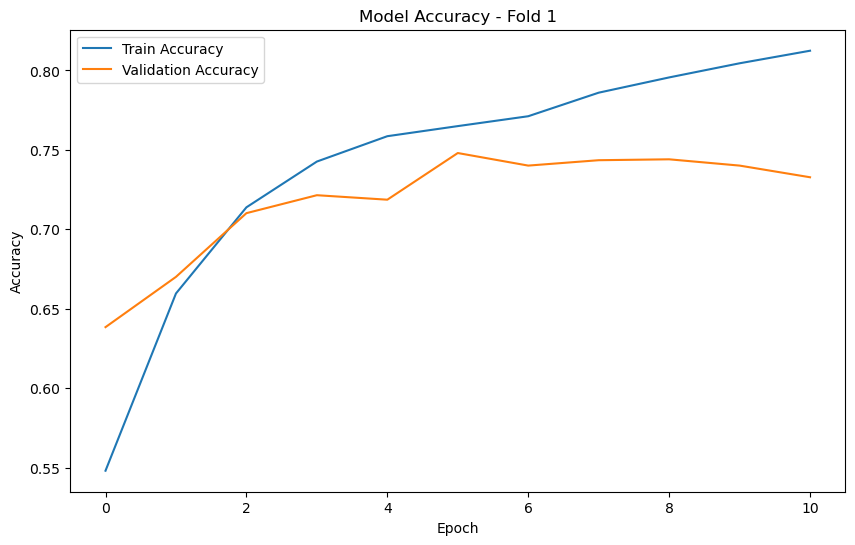

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Results:
Accuracy: 0.7480
MCC: 0.4900
Sensitivity: 0.8008
Specificity: 0.6849

Fold 2/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5320 - loss: 0.6899 - val_accuracy: 0.6119 - val_loss: 0.6525
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6613 - loss: 0.6257 - val_accuracy: 0.6712 - val_loss: 0.6009
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7117 - loss: 0.5706 - val_accuracy: 0.7164 - val_loss: 0.5498
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7431 - loss: 0.5220 - val_accuracy: 0.7311 - val_loss: 0.5409
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7675 - loss: 0.4985 - val_accuracy: 0.7294 - val_loss: 0.5330
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7772 - loss: 0.4800 - val_accuracy: 0.7345 - val_loss: 0.5287
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7828 - loss: 0.4690 - val_accuracy: 0.7367 - val_loss: 0.5418
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7954 - loss: 0.4512 - val_accuracy: 0.741

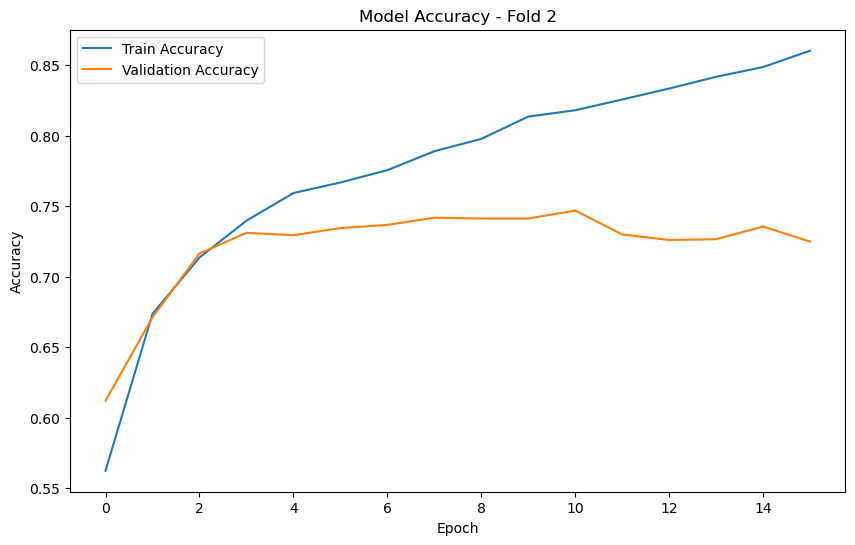

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2 Results:
Accuracy: 0.7469
MCC: 0.4997
Sensitivity: 0.8766
Specificity: 0.6000

Fold 3/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5036 - loss: 0.6934 - val_accuracy: 0.5045 - val_loss: 0.6892
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5586 - loss: 0.6731 - val_accuracy: 0.6282 - val_loss: 0.6553
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6757 - loss: 0.6351 - val_accuracy: 0.6689 - val_loss: 0.6314
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7050 - loss: 0.6089 - val_accuracy: 0.6989 - val_loss: 0.6105
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7286 - loss: 0.5846 - val_accuracy: 0.7220 - val_loss: 0.5929
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7362 - loss: 0.5703 - val_accuracy: 0.7198 - val_loss: 0.5867
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7456 - loss: 0.5556 - val_accuracy: 0.7311 - val_loss: 0.5793
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7544 - loss: 0.5481 - val_accuracy: 0.739

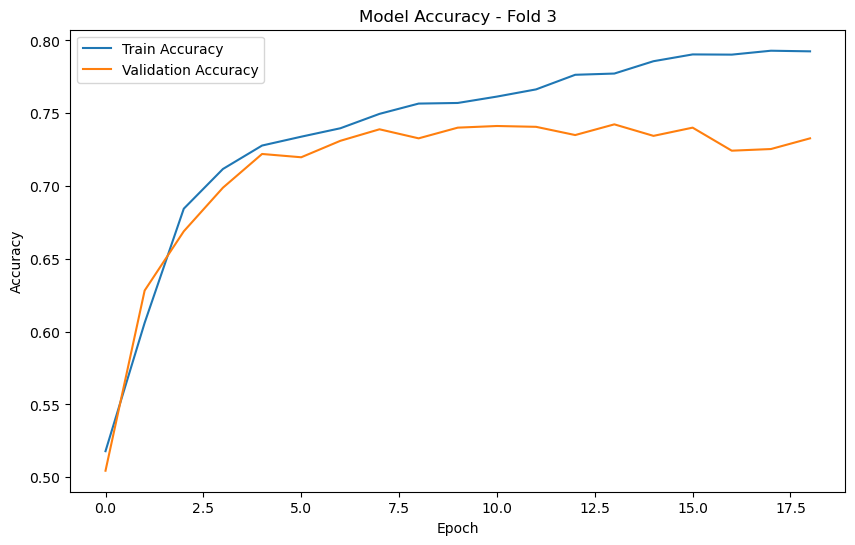

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 3 Results:
Accuracy: 0.7424
MCC: 0.4873
Sensitivity: 0.8007
Specificity: 0.6830

Fold 4/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5347 - loss: 0.6868 - val_accuracy: 0.6463 - val_loss: 0.6328
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6693 - loss: 0.6148 - val_accuracy: 0.6921 - val_loss: 0.5967
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7092 - loss: 0.5760 - val_accuracy: 0.7203 - val_loss: 0.5572
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7374 - loss: 0.5321 - val_accuracy: 0.7316 - val_loss: 0.5385
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7507 - loss: 0.5153 - val_accuracy: 0.7339 - val_loss: 0.5287
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7530 - loss: 0.5009 - val_accuracy: 0.7299 - val_loss: 0.5289
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7648 - loss: 0.4824 - val_accuracy: 0.7356 - val_loss: 0.5255
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7831 - loss: 0.4694 - val_accuracy: 0.739

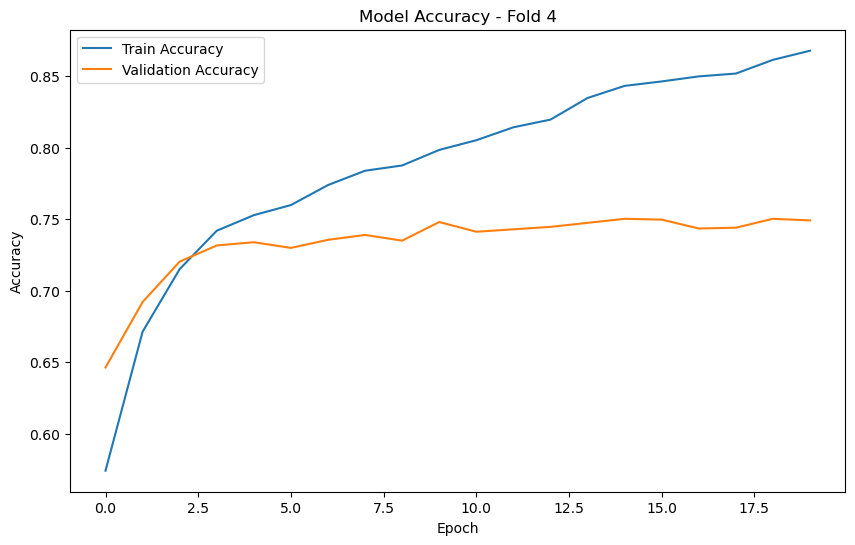

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 4 Results:
Accuracy: 0.7503
MCC: 0.5031
Sensitivity: 0.7964
Specificity: 0.7048

Fold 5/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5169 - loss: 0.6914 - val_accuracy: 0.6158 - val_loss: 0.6590
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6408 - loss: 0.6384 - val_accuracy: 0.6904 - val_loss: 0.5907
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7052 - loss: 0.5743 - val_accuracy: 0.7209 - val_loss: 0.5505
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7302 - loss: 0.5371 - val_accuracy: 0.7339 - val_loss: 0.5368
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7532 - loss: 0.5108 - val_accuracy: 0.7401 - val_loss: 0.5312
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7554 - loss: 0.4938 - val_accuracy: 0.7407 - val_loss: 0.5258
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7713 - loss: 0.4843 - val_accuracy: 0.7469 - val_loss: 0.5260
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7799 - loss: 0.4720 - val_accuracy: 0.748

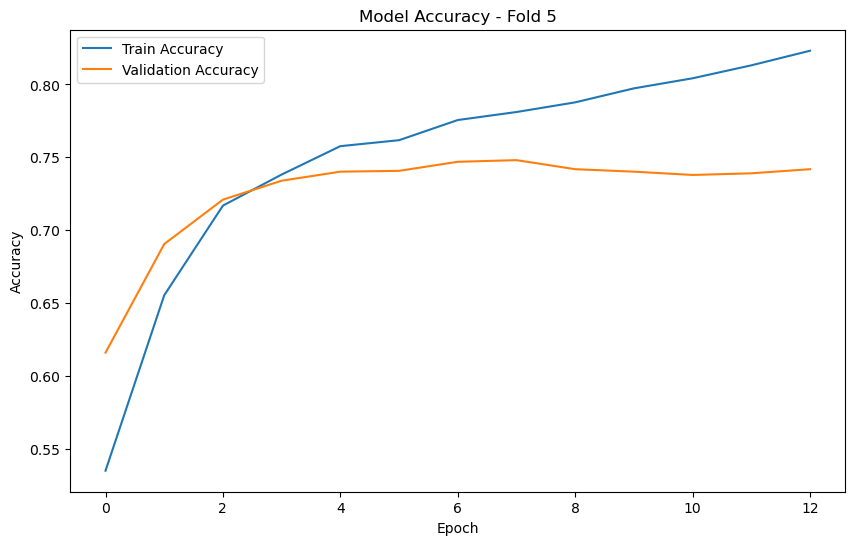

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5 Results:
Accuracy: 0.7480
MCC: 0.4974
Sensitivity: 0.8186
Specificity: 0.6725

Average Cross-validation Results:
ACC: 0.7471 ± 0.0026
MCC: 0.4955 ± 0.0059
SN: 0.8186 ± 0.0300
SP: 0.6690 ± 0.0361

Final Test Set Results:
Accuracy: 0.6756
MCC: 0.2977
Sensitivity: 0.8542
Specificity: 0.6584
Confusion Matrix:
[[1644  853]
 [  35  205]]


In [15]:
if __name__ == "__main__":
    model = train_and_evaluate()